### homework1：实战seq2seq

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据加载

In [2]:
import unicodedata
import re
from sklearn.model_selection import train_test_split


# 定义一个函数，将Unicode字符串转换为ASCII字符串
def unicode_to_ascii(s):
    # 使用unicodedata.normalize方法将字符串s转换为NFD形式。
    # NFD（Normalization Form D）是一种Unicode规范化形式，它将字符分解为基本字符和组合字符。
    # 例如，字符'é'会被分解为'e'和一个组合的重音符号。
    normalized_string = unicodedata.normalize('NFD', s)

    # 使用列表推导式遍历规范化后的字符串中的每个字符。
    # unicodedata.category(c)返回字符c的Unicode类别。
    # 'Mn'表示“非间距标记”（例如重音符号），我们通过条件判断去除这些字符。
    ascii_string = ''.join(c for c in normalized_string if unicodedata.category(c) != 'Mn')

    # 返回转换后的ASCII字符串
    return ascii_string


# 测试unicode_to_ascii函数
# 定义一个英文句子和一个西班牙语句子，使用u前缀表示Unicode字符串
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

# 打印转换后的英文句子
print(unicode_to_ascii(en_sentence))
# 输出: May I borrow this book?

# 打印转换后的西班牙语句子
print(unicode_to_ascii(sp_sentence))
# 输出: ¿Puedo tomar prestado este libro?

May I borrow this book?
¿Puedo tomar prestado este libro?


In [3]:
def preprocess_sentence(w):
    # 1. 将字符串转换为小写，并去掉首尾多余的空格
    # 2. 调用 unicode_to_ascii 函数，将 Unicode 字符转换为 ASCII 字符（去除重音符号等）
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如："he is a boy." => "he is a boy . "
    # 使用正则表达式匹配标点符号（?.!,¿），并在其前后添加空格
    w = re.sub(r"([?.!,¿])", r" \1 ", w)

    # 将多个连续的空格替换为一个空格
    # 因为上一步可能会引入多余的空格
    w = re.sub(r'[" "]+', " ", w)

    # 除了字母 (a-z, A-Z) 和标点符号（".", "?", "!", ",", "¿"），将所有其他字符替换为空格
    # 这样可以去除数字、特殊符号等不需要的字符
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    # 去掉字符串首尾的空格，确保最终结果干净
    w = w.rstrip().strip()

    return w


# 测试 preprocess_sentence 函数
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

# 打印处理后的英文句子
print(preprocess_sentence(en_sentence))
# 输出: may i borrow this book ?

# 打印处理后的西班牙语句子
print(preprocess_sentence(sp_sentence))
# 输出: ¿ puedo tomar prestado este libro ?

# 打印处理后的西班牙语句子的 UTF-8 编码
print(preprocess_sentence(sp_sentence).encode('utf-8'))
# 输出: b' \xc2\xbf puedo tomar prestado este libro ?'

may i borrow this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


Dataset

In [4]:
#zip例子
a = [[1, 2], [4, 5], [7, 8]]
zipped = list(zip(*a))
print(zipped)

[(1, 4, 7), (2, 5, 8)]


In [5]:
# 使用 np.random.choice 函数生成随机选择的数组
split_index1 = np.random.choice(
    a=["train", "test"],  # 从 "train" 和 "test" 两个选项中进行选择
    replace=True,  # 允许重复选择，即同一个元素可以被多次选择
    p=[0.9, 0.1],  # 选择 "train" 的概率为 90%，选择 "test" 的概率为 10%
    size=100  # 生成一个包含 100 个元素的数组
)

# 输出 split_index1
split_index1

array(['train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'test', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'test', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'test', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train'], dty

In [7]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class LangPairDataset(Dataset):
    # 数据文件路径
    fpath = Path(r"./data_spa_en/spa.txt")
    # 缓存文件路径
    cache_path = Path(r"./.cache/lang_pair.npy")
    # 按照 9:1 的比例随机划分训练集和测试集
    split_index = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=118964)
    

    def __init__(self, mode="train", cache=False):
        # 如果没有缓存，或者缓存文件不存在，则处理数据并保存缓存
        if cache or not self.cache_path.exists():
            # 创建缓存文件夹（如果不存在）
            self.cache_path.parent.mkdir(parents=True, exist_ok=True)
            # 打开数据文件并读取所有行
            with open(self.fpath, "r", encoding="utf8") as file:
                lines = file.readlines()
                # 对每一行数据进行预处理，分割成目标语言和源语言
                lang_pair = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines]
                # 将目标语言和源语言分离
                trg, src = zip(*lang_pair)
                # 转换为 numpy 数组
                trg = np.array(trg)
                src = np.array(src)
                # 将数据保存为 npy 文件，方便下次直接读取
                np.save(self.cache_path, {"trg": trg, "src": src})
        else:
            # 如果缓存文件存在，则直接加载缓存数据
            lang_pair = np.load(self.cache_path, allow_pickle=True).item()
            trg = lang_pair["trg"]
            src = lang_pair["src"]
            
        # 根据 mode（train/test）从 split_index 中筛选出对应的数据
        self.trg = trg[self.split_index == mode]  # 目标语言（英语）
        self.src = src[self.split_index == mode]  # 源语言（西班牙语）
    
    def __getitem__(self, index):
        # 返回指定索引的源语言和目标语言对
        return self.src[index], self.trg[index]

    def __len__(self):
        # 返回数据集的长度
        return len(self.src)


# 创建训练集和测试集实例
train_ds = LangPairDataset("train")
test_ds = LangPairDataset("test")

In [8]:
print("source: {}\ntarget: {}".format(*train_ds[-1]))

source: si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado .
target: if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .


Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现不共享的方案。

In [9]:
from collections import Counter


def get_word_idx(ds, mode="src", threshold=2):
    # 初始化词表，包含特殊 token
    word2idx = {
        "[PAD]": 0,  # 填充 token，用于填充短句子
        "[BOS]": 1,  # 句子开始 token
        "[UNK]": 2,  # 未知 token，用于表示词表中未出现的词
        "[EOS]": 3,  # 句子结束 token
    }
    # 反向词表，用于根据索引查找单词
    idx2word = {value: key for key, value in word2idx.items()}
    # 当前词表的下一个可用索引
    index = len(idx2word)
    # 设置词频阈值，低于此阈值的单词将被忽略
    threshold = 1

    # 将数据集中所有句子拼接成一个长字符串，然后按空格分割成单词列表
    # 如果数据集很大，建议使用 for 循环逐句处理，避免内存不足
    word_list = " ".join([pair[0 if mode == "src" else 1] for pair in ds]).split()
    # 统计单词频率
    counter = Counter(word_list)
    print("word count:", len(counter))

    # 遍历单词频率统计结果
    for token, count in counter.items():
        # 如果单词出现次数大于等于阈值，则加入词表
        if count >= threshold:
            word2idx[token] = index  # 加入正向词表
            idx2word[index] = token  # 加入反向词表
            index += 1  # 更新下一个可用索引

    return word2idx, idx2word


# 生成源语言（西班牙语）和目标语言（英语）的词表
src_word2idx, src_idx2word = get_word_idx(train_ds, "src")  # 源语言词表（西班牙语）
trg_word2idx, trg_idx2word = get_word_idx(train_ds, "trg")  # 目标语言词表（英语）

word count: 23745
word count: 12475


In [10]:
import torch


class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        # 初始化词表和参数
        self.word2idx = word2idx  # 单词到索引的映射
        self.idx2word = idx2word  # 索引到单词的映射
        self.max_length = max_length  # 最大序列长度
        self.pad_idx = pad_idx  # 填充 token 的索引
        self.bos_idx = bos_idx  # 句子开始 token 的索引
        self.eos_idx = eos_idx  # 句子结束 token 的索引
        self.unk_idx = unk_idx  # 未知 token 的索引

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """将文本列表编码为索引列表
        - padding_first: 是否在前面填充
        - add_bos: 是否添加句子开始 token
        - add_eos: 是否添加句子结束 token
        - return_mask: 是否返回掩码（用于指示哪些是填充 token）
        """
        # 计算最大长度（不超过 self.max_length）
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []  # 存储编码后的索引列表

        for text in text_list:
            # 将单词转换为索引，未知单词用 unk_idx 代替
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]
            # 添加句子开始 token
            if add_bos:
                indices = [self.bos_idx] + indices
            # 添加句子结束 token
            if add_eos:
                indices = indices + [self.eos_idx]
            # 在前面或后面填充
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)

        # 将索引列表转换为 tensor
        input_ids = torch.tensor(indices_list)
        # 生成掩码（1 表示填充 token，0 表示真实 token）
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)

        # 返回编码结果和掩码（如果 return_mask 为 True）
        return input_ids if not return_mask else (input_ids, masks)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """将索引列表解码为文本列表
        - remove_bos: 是否移除句子开始 token
        - remove_eos: 是否移除句子结束 token
        - remove_pad: 是否移除填充 token
        - split: 是否返回单词列表（而不是拼接的句子）
        """
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")  # 将索引转换为单词，未知索引用 "[UNK]" 代替
                # 根据参数决定是否移除特殊 token
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            # 将单词列表拼接为句子或直接返回单词列表
            text_list.append(" ".join(text) if not split else text)
        return text_list


# 创建源语言和目标语言的 tokenizer
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word)  # 源语言 tokenizer
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word)  # 目标语言 tokenizer

# 测试编码和解码功能
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices, mask = trg_tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True, return_mask=True)
decode_text = trg_tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)

# 打印结果
print("raw text" + '-' * 10)
for raw in raw_text:
    print(raw)

print("mask" + '-' * 10)
for m in mask:
    print(m)

print("indices" + '-' * 10)
for index in indices:
    print(index)

print("decode text" + '-' * 10)
for decode in decode_text:
    print(decode)

raw text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
indices----------
tensor([   1,   17, 3222,    3,    0,    0,    0])
tensor([   1,    2, 3883,    2,  737,    2,    3])
tensor([   1,  119,  228,  106, 1274,    3,    0])
decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


DataLoader

In [11]:
def collate_fct(batch):
    # 1. 对 batch 中的源语言和目标语言进行分词
    src_words = [pair[0].split() for pair in batch]  # 取 batch 内第 0 列（源语言）进行分词，赋给 src_words
    trg_words = [pair[1].split() for pair in batch]  # 取 batch 内第 1 列（目标语言）进行分词，赋给 trg_words

    # 2. 对源语言进行编码，生成编码器输入
    # 编码器输入格式: [PAD] [BOS] src [EOS]
    # - padding_first=True: 在序列前面填充 [PAD]
    # - add_bos=True: 在序列开头添加 [BOS]（Begin of Sentence）
    # - add_eos=True: 在序列结尾添加 [EOS]（End of Sentence）
    # - return_mask=True: 返回掩码，用于标识哪些位置是有效数据（非填充部分）
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_words, padding_first=True, add_bos=True, add_eos=True, return_mask=True
    )

    # 3. 对目标语言进行编码，生成解码器输入
    # 解码器输入格式: [BOS] trg [PAD]
    # - padding_first=False: 在序列后面填充 [PAD]
    # - add_bos=True: 在序列开头添加 [BOS]
    # - add_eos=False: 不在序列结尾添加 [EOS]
    # - return_mask=False: 不返回掩码
    decoder_inputs = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False
    )

    # 4. 对目标语言进行编码，生成解码器标签
    # 解码器标签格式: trg [EOS] [PAD]
    # - padding_first=False: 在序列后面填充 [PAD]
    # - add_bos=False: 不在序列开头添加 [BOS]
    # - add_eos=True: 在序列结尾添加 [EOS]
    # - return_mask=True: 返回掩码，用于标识哪些位置是有效数据（非填充部分）
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
    )

    # 5. 返回处理后的数据
    return {
        "encoder_inputs": encoder_inputs.to(device=device),  # 编码器输入，移动到指定设备（如 GPU）
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),  # 编码器输入掩码，移动到指定设备
        "decoder_inputs": decoder_inputs.to(device=device),  # 解码器输入，移动到指定设备
        "decoder_labels": decoder_labels.to(device=device),  # 解码器标签，移动到指定设备
        "decoder_labels_mask": decoder_labels_mask.to(device=device),  # 解码器标签掩码，移动到指定设备
        # 掩码用于去除填充部分的影响，在计算损失时忽略填充部分
    }
    # 当返回的数据较多时，用字典（dict）返回比较合理，便于后续使用

In [12]:
sample_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fct)

#两次执行这个代码效果不一样，因为每次执行都会shuffle
for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     1,
            75,   310,  1538,    30,    90,  1535,     5,     3],
        [    1,    32,  1454,   883,    30,    90,    32, 10559,    89,  1326,
             5,    49,  4973,  2578,    69,   378,     5,     3]],
       device='cuda:0')
encoder_inputs_mask
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')
decoder_inputs
tensor([[   1,  227,   81,  436,  205,   32,  974,    5,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   1,   18,  126,  153,  673,  874,   18,  795,  345,   12,   89,    5,
          673, 1013,  228,   28,  345,   89,    5]], device='cuda:0')
decoder_labels
tensor([[ 227,   81,  436,  205,   32,  974,    5,    3,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [  18,  126,  153,  673,  874,   18,  795,

定义模型

In [13]:
class Encoder(nn.Module):
    def __init__(
            self,
            vocab_size,  # 词汇表大小，表示输入词汇的总数
            embedding_dim=256,  # 词嵌入维度，将每个词映射为一个固定大小的向量
            hidden_dim=1024,  # GRU 隐藏层的维度
            num_layers=1,  # GRU 的层数
    ):
        super().__init__()  # 调用父类 nn.Module 的初始化方法

        # 1. 词嵌入层：将输入的词索引映射为稠密的词向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. GRU 层：用于捕捉序列的上下文信息
        self.gru = nn.GRU(
            embedding_dim,  # 输入特征的维度（词嵌入的维度）
            hidden_dim,  # 隐藏状态的维度
            num_layers=num_layers,  # GRU 的层数
            batch_first=True  # 输入数据的形状为 [batch_size, sequence_length, feature_dim]
        )

    def forward(self, encoder_inputs):
        # encoder_inputs.shape = [batch_size, sequence_length]
        # 输入是批量的词索引序列，形状为 [batch_size, sequence_length]

        # 1. 将词索引映射为词向量
        embeds = self.embedding(encoder_inputs)
        # embeds.shape = [batch_size, sequence_length, embedding_dim]

        # 2. 将词向量输入 GRU，获取序列的输出和最终的隐藏状态
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch_size, sequence_length, hidden_dim]
        # hidden.shape = [num_layers, batch_size, hidden_dim]

        return seq_output, hidden

In [14]:
#把上面的Encoder写一个例子，看看输出的shape
encoder = Encoder(vocab_size=100, embedding_dim=256, hidden_dim=1024, num_layers=4)
encoder_inputs = torch.randint(0, 100, (2, 50))
encoder_outputs, hidden = encoder(encoder_inputs)
print(encoder_outputs.shape)
print(hidden.shape)
print(encoder_outputs[:, -1, :])
print(hidden[-1, :, :])  #取最后一层的hidden

torch.Size([2, 50, 1024])
torch.Size([4, 2, 1024])
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)


In [15]:
query1 = torch.randn(2, 1024)
query1.unsqueeze(1).shape  #增加维度

torch.Size([2, 1, 1024])

BahdanauAttention公式  
$$score = FC(tanh(FC(EO) + FC(H)))$$   

$FC(EO)$的$FC$是$Wk$,$FC(H)$的$FC$是$Wq$,最外面的$FC$是$V$ 

$$attention_weights = softmax(score, axis = 1)$$  

$$context = sum(attention_weights * EO, axis = 1)$$  

对$EO$做加权求和，得到上下文向量

In [16]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim=1024):
        super().__init__()
        # 1. 定义线性变换层
        self.Wk = nn.Linear(hidden_dim, hidden_dim)  # 对 keys（编码器输出）做线性变换
        self.Wq = nn.Linear(hidden_dim, hidden_dim)  # 对 query（解码器隐藏状态）做线性变换
        self.V = nn.Linear(hidden_dim, 1)  # 将变换后的结果映射为一个标量（注意力分数）

    def forward(self, query, keys, values, attn_mask=None):
        """
        正向传播
        :param query: 解码器的隐藏状态，shape = [batch size, hidden_dim]
        :param keys: 编码器的输出（keys），shape = [batch size, sequence length, hidden_dim]
        :param values: 编码器的输出（values），shape = [batch size, sequence length, hidden_dim]
        :param attn_mask: 注意力掩码，shape = [batch size, sequence length]，用于屏蔽填充部分
        :return:
            - context_vector: 上下文向量，shape = [batch size, hidden_dim]
            - scores: 注意力分数，shape = [batch size, sequence length, 1]
        """
        # 1. 调整 query 的形状
        # query.shape = [batch size, hidden_dim] --> [batch size, 1, hidden_dim]
        query = query.unsqueeze(-2)

        # 2. 计算注意力分数
        # self.Wk(keys): [batch size, sequence length, hidden_dim]
        # self.Wq(query): [batch size, 1, hidden_dim]
        # self.Wk(keys) + self.Wq(query): [batch size, sequence length, hidden_dim]
        # F.tanh(...): 应用 tanh 激活函数
        # self.V(...): 将结果映射为标量，shape = [batch size, sequence length, 1]
        scores = self.V(F.tanh(self.Wk(keys) + self.Wq(query)))

        # 3. 处理注意力掩码
        if attn_mask is not None:
            # attn_mask.shape = [batch size, sequence length] --> [batch size, sequence length, 1]
            attn_mask = attn_mask.unsqueeze(-1)
            # 将掩码中为 1 的位置（填充部分）的分数设置为一个极小的值（-inf）
            scores += attn_mask * -1e16

        # 4. 计算注意力权重
        # 对 scores 在序列长度维度上做 softmax，得到注意力权重
        scores = F.softmax(scores, dim=-2)  # shape = [batch size, sequence length, 1]

        # 5. 计算上下文向量
        # torch.mul(scores, values): 将注意力权重与 values 相乘
        # .sum(dim=-2): 在序列长度维度上求和，得到上下文向量
        context_vector = torch.mul(scores, values).sum(dim=-2)  # shape = [batch size, hidden_dim]

        # 6. 返回上下文向量和注意力分数
        return context_vector, scores

In [17]:
#tensor矩阵相乘
a = torch.randn(2, 3)
b = torch.randn(2, 3)
c = torch.mul(a, b)  #增加维度
print(c.shape)

torch.Size([2, 3])


In [18]:
#把上面的BahdanauAttention写一个例子，看看输出的shape
attention = BahdanauAttention(hidden_dim=1024)
query = torch.randn(2, 1024)  #Decoder的隐藏状态
keys = torch.randn(2, 50, 1024)  #EO
values = torch.randn(2, 50, 1024)  #EO
attn_mask = torch.randint(0, 2, (2, 50))
context_vector, scores = attention(query, keys, values, attn_mask)
print(context_vector.shape)
print(scores.shape)

torch.Size([2, 1024])
torch.Size([2, 50, 1])


In [19]:
class Decoder(nn.Module):
    def __init__(
            self,
            vocab_size,  # 词汇表大小，表示输出词汇的总数
            embedding_dim=256,  # 词嵌入维度，将每个词映射为一个固定大小的向量
            hidden_dim=1024,  # GRU 隐藏层的维度
            num_layers=1,  # GRU 的层数
    ):
        super(Decoder, self).__init__()  # 调用父类 nn.Module 的初始化方法

        # 1. 词嵌入层：将输入的词索引映射为稠密的词向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. GRU 层：用于捕捉序列的上下文信息
        # 输入维度为 embedding_dim + hidden_dim（词嵌入 + 上下文向量）
        # 输出维度为 hidden_dim
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # 3. 全连接层：将 GRU 的输出映射为词汇表的概率分布
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # 4. Dropout 层：用于防止过拟合
        self.dropout = nn.Dropout(0.6)

        # 5. 注意力机制：用于计算上下文向量
        self.attention = BahdanauAttention(hidden_dim)

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        """
        正向传播
        :param decoder_input: 解码器的输入，shape = [batch size, 1]
        :param hidden: 解码器的隐藏状态，shape = [batch size, hidden_dim]
        :param encoder_outputs: 编码器的输出，shape = [batch size, sequence length, hidden_dim]
        :param attn_mask: 注意力掩码，shape = [batch size, sequence length]，用于屏蔽填充部分
        :return:
            - logits: 输出词汇表的概率分布，shape = [batch size, 1, vocab size]
            - hidden: 更新后的隐藏状态，shape = [batch size, hidden_dim]
            - attention_score: 注意力分数，shape = [batch size, sequence length, 1]
        """
        # 1. 检查输入形状
        assert len(decoder_input.shape) == 2 and decoder_input.shape[
            -1] == 1, f"decoder_input.shape = {decoder_input.shape} is not valid"
        assert len(hidden.shape) == 2, f"hidden.shape = {hidden.shape} is not valid"
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape} is not valid"

        # 2. 计算上下文向量
        context_vector, attention_score = self.attention(
            query=hidden, keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask
        )
        # context_vector.shape = [batch size, hidden_dim]
        # attention_score.shape = [batch size, sequence length, 1]

        # 3. 将解码器输入映射为词向量
        embeds = self.embedding(decoder_input)
        # embeds.shape = [batch size, 1, embedding_dim]

        # 4. 将上下文向量与词向量拼接
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1)
        # embeds.shape = [batch size, 1, embedding_dim + hidden_dim]

        # 5. 将拼接后的向量输入 GRU
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch size, 1, hidden_dim]
        # hidden.shape = [batch size, hidden_dim]

        # 6. 将 GRU 的输出映射为词汇表的概率分布
        logits = self.fc(self.dropout(seq_output))
        # logits.shape = [batch size, 1, vocab size]

        # 7. 返回结果
        return logits, hidden, attention_score

In [20]:
class Sequence2Sequence(nn.Module):
    def __init__(
            self,
            src_vocab_size,  # 输入词典大小
            trg_vocab_size,  # 输出词典大小
            encoder_embedding_dim=256,  # 编码器的词嵌入维度
            encoder_hidden_dim=1024,  # 编码器的隐藏层维度
            encoder_num_layers=1,  # 编码器的层数
            decoder_embedding_dim=256,  # 解码器的词嵌入维度
            decoder_hidden_dim=1024,  # 解码器的隐藏层维度
            decoder_num_layers=1,  # 解码器的层数
            bos_idx=1,  # 开始标记（Begin of Sentence）的索引
            eos_idx=3,  # 结束标记（End of Sentence）的索引
            max_length=512,  # 生成序列的最大长度
    ):
        super(Sequence2Sequence, self).__init__()  # 调用父类 nn.Module 的初始化方法

        # 1. 初始化模型参数
        self.bos_idx = bos_idx  # 开始标记
        self.eos_idx = eos_idx  # 结束标记
        self.max_length = max_length  # 生成序列的最大长度

        # 2. 定义编码器
        self.encoder = Encoder(
            src_vocab_size,
            embedding_dim=encoder_embedding_dim,
            hidden_dim=encoder_hidden_dim,
            num_layers=encoder_num_layers,
        )

        # 3. 定义解码器
        self.decoder = Decoder(
            trg_vocab_size,
            embedding_dim=decoder_embedding_dim,
            hidden_dim=decoder_hidden_dim,
            num_layers=decoder_num_layers,
        )

    def forward(self, *, encoder_inputs, decoder_inputs, attn_mask=None):
        """
        正向传播（训练模式）
        :param encoder_inputs: 编码器输入，shape = [batch size, sequence length]
        :param decoder_inputs: 解码器输入，shape = [batch size, sequence length]
        :param attn_mask: 注意力掩码，shape = [batch size, sequence length]
        :return:
            - logits: 输出词汇表的概率分布，shape = [batch size, sequence length, vocab size]
            - scores: 注意力分数，shape = [batch size, sequence length, sequence length]
        """
        # 1. 编码器部分
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        # encoder_outputs.shape = [batch size, sequence length, hidden_dim]
        # hidden.shape = [num_layers, batch size, hidden_dim]

        # 2. 解码器部分（使用 Teacher Forcing）
        bs, seq_len = decoder_inputs.shape
        logits_list = []  # 存储每个时间步的预测结果
        scores_list = []  # 存储每个时间步的注意力分数

        for i in range(seq_len):
            # 每次迭代生成一个时间步的预测
            logits, hidden, score = self.decoder(
                decoder_inputs[:, i:i + 1],  # 当前时间步的输入
                hidden[-1],  # 使用编码器的最后一层隐藏状态
                encoder_outputs,  # 编码器的输出
                attn_mask=attn_mask  # 注意力掩码
            )
            logits_list.append(logits)  # 记录预测的 logits
            scores_list.append(score)  # 记录注意力分数

        # 3. 返回结果
        return torch.cat(logits_list, dim=-2), torch.cat(scores_list, dim=-1)

    @torch.no_grad()  # 不计算梯度
    def infer(self, encoder_input, attn_mask=None):
        """
        推理模式（生成序列）
        :param encoder_input: 编码器输入，shape = [1, sequence length]
        :param attn_mask: 注意力掩码，shape = [1, sequence length]
        :return:
            - pred_list: 生成的序列（词索引列表）
            - scores: 注意力分数，shape = [1, sequence length, sequence length]
        """
        # 1. 编码器部分
        encoder_outputs, hidden = self.encoder(encoder_input)
        # encoder_outputs.shape = [1, sequence length, hidden_dim]
        # hidden.shape = [num_layers, 1, hidden_dim]

        # 2. 解码器部分（从开始标记开始生成序列）
        decoder_input = torch.Tensor([self.bos_idx]).reshape(1, 1).to(dtype=torch.int64)  # 开始标记
        decoder_pred = None
        pred_list = []  # 存储生成的序列
        score_list = []  # 存储注意力分数

        for _ in range(self.max_length):
            # 每次迭代生成一个时间步的预测
            logits, hidden, score = self.decoder(
                decoder_input,  # 当前时间步的输入
                hidden[-1],  # 使用解码器的最后一层隐藏状态
                encoder_outputs,  # 编码器的输出
                attn_mask=attn_mask  # 注意力掩码
            )
            # 使用贪心搜索（Greedy Search）选择概率最大的词
            decoder_pred = logits.argmax(dim=-1)
            decoder_input = decoder_pred  # 将当前预测作为下一个时间步的输入
            pred_list.append(decoder_pred.reshape(-1).item())  # 记录生成的词索引
            score_list.append(score)  # 记录注意力分数

            # 如果生成结束标记，则停止生成
            if decoder_pred == self.eos_idx:
                break

        # 3. 返回结果
        return pred_list, torch.cat(score_list, dim=-1)

In [21]:
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
#做model的前向传播，看看输出的shape
encoder_inputs = torch.randint(0, 100, (2, 50))
decoder_inputs = torch.randint(0, 100, (2, 50))
attn_mask = torch.randint(0, 2, (2, 50))
logits, scores = model(encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs, attn_mask=attn_mask)
print(logits.shape)
print(scores.shape)

torch.Size([2, 50, 12479])
torch.Size([2, 50, 50])


In [22]:
#帮我计算一下model的总参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 35,187,904 trainable parameters


In [23]:
#帮我初始化一个4层的GRU的model
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx), encoder_num_layers=4,
                          decoder_num_layers=4)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 72,973,504 trainable parameters


训练

损失函数：

In [24]:
def cross_entropy_with_padding(logits, labels, padding_mask=None):
    """
    计算带填充的交叉熵损失
    :param logits: 模型的输出，shape = [batch size, sequence length, num of classes]
    :param labels: 真实标签，shape = [batch size, sequence length]
    :param padding_mask: 填充掩码，shape = [batch size, sequence length]，1 表示填充部分，0 表示有效部分
    :return: 计算得到的损失值
    """
    # 1. 获取输入的形状
    bs, seq_len, nc = logits.shape  # batch size, sequence length, number of classes

    # 2. 计算交叉熵损失（不进行 reduce，即不对 batch 求平均）
    loss = F.cross_entropy(
        logits.reshape(bs * seq_len, nc),  # 将 logits 展平为 [batch size * sequence length, num of classes]
        labels.reshape(-1),  # 将 labels 展平为 [batch size * sequence length]
        reduction='none'  # 不进行 reduce，返回每个位置的损失
    )
    # loss.shape = [batch size * sequence length]

    # 3. 处理填充部分
    if padding_mask is None:
        # 如果没有提供 padding_mask，则直接计算所有位置的损失均值
        loss = loss.mean()
    else:
        # 如果提供了 padding_mask，则去除填充部分的损失
        padding_mask = 1 - padding_mask.reshape(-1)  # 将 padding_mask 展平并取反，1 表示有效部分，0 表示填充部分
        loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()  # 计算有效部分的损失均值

    # 4. 返回最终的损失值
    return loss

callback函数：

In [25]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

2025-01-31 12:18:05.099946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 12:18:05.409886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738297085.520381     304 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738297085.552752     304 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 12:18:05.844678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

savebest

In [26]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

early stopping

In [27]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

training & valuating

In [28]:
@torch.no_grad()  # 不计算梯度，节省内存和计算资源
def evaluating(model, dataloader, loss_fct):
    """
    在验证集或测试集上评估模型性能
    :param model: 训练好的模型
    :param dataloader: 数据加载器，用于加载验证集或测试集数据
    :param loss_fct: 损失函数，用于计算模型输出与真实标签之间的损失
    :return: 验证集或测试集上的平均损失
    """
    loss_list = []  # 存储每个批次的损失

    # 遍历数据加载器中的每个批次
    for batch in dataloader:
        # 1. 从批次中提取数据
        encoder_inputs = batch["encoder_inputs"]  # 编码器输入，shape = [batch size, sequence length]
        encoder_inputs_mask = batch["encoder_inputs_mask"]  # 编码器输入掩码，shape = [batch size, sequence length]
        decoder_inputs = batch["decoder_inputs"]  # 解码器输入，shape = [batch size, sequence length]
        decoder_labels = batch["decoder_labels"]  # 解码器标签，shape = [batch size, sequence length]
        decoder_labels_mask = batch["decoder_labels_mask"]  # 解码器标签掩码，shape = [batch size, sequence length]

        # 2. 前向计算
        logits, _ = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            attn_mask=encoder_inputs_mask
        )
        # logits: 模型输出的概率分布，shape = [batch size, sequence length, vocab size]
        # _: 注意力分数（未使用）

        # 3. 计算损失
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)
        # loss: 当前批次的损失值

        # 4. 记录损失
        loss_list.append(loss.cpu().item())  # 将损失值从 GPU 移动到 CPU，并转换为 Python 数值

    # 5. 返回平均损失
    return np.mean(loss_list)

In [29]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1
    model.train() # 切换到训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]

                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                logits, _ = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    attn_mask=encoder_inputs_mask
                    )
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 切换到验证模式
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train() # 切换到训练模式

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            lr=optimizer.param_groups[0]["lr"],
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss}) # 更新进度条

    return record_dict

In [30]:
epoch = 20
batch_size = 64

model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = cross_entropy_with_padding
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-seq2seq"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}", save_step=200, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [31]:
model = model.to(device)
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=200
    )

 23%|██▎       | 7599/33420 [09:06<30:57, 13.90it/s, epoch=3, loss=1.57, val_loss=1.25]  

Early stop at epoch 4 / global_step 7600


In [32]:
#计算模型参数量
sum(i[1].numel() for i in model.named_parameters())

35187904

In [33]:
33520/20

1676.0

In [34]:
118964*0.9/64

1672.93125

In [35]:
record["train"][-1]

{'loss': 1.0774604082107544, 'step': 7600}

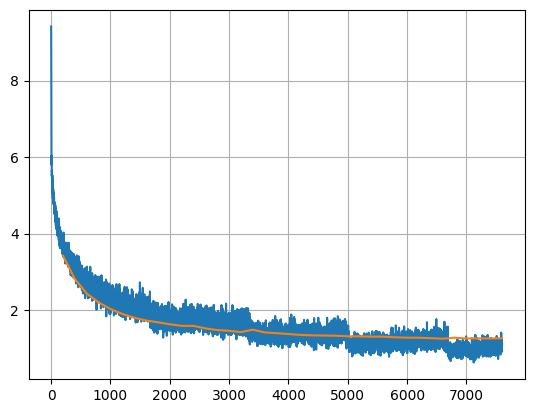

In [36]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

推理

- 接下来进行翻译推理，并作出注意力的热度图

In [38]:
# load checkpoints,如何上线
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", weights_only=True,map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def draw_attention_map(self, scores, src_words_list, trg_words_list):
        """绘制注意力热力图

        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        plt.matshow(scores.T, cmap='viridis') # 注意力矩阵,显示注意力分数值
        # 获取当前的轴
        ax = plt.gca()

        # 设置热图中每个单元格的分数的文本
        for i in range(scores.shape[0]): #输入
            for j in range(scores.shape[1]): #输出
                ax.text(j, i, f'{scores[i, j]:.2f}',  # 格式化数字显示
                               ha='center', va='center', color='k')

        plt.xticks(range(scores.shape[0]), src_words_list)
        plt.yticks(range(scores.shape[1]), trg_words_list)
        plt.show()

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0] #通过tokenizer转换成文字

        src_decoded = self.src_tokenizer.decode(
            encoder_input.tolist(),
            split=True,
            remove_bos=False,
            remove_eos=False
            )[0] #对输入编码id进行解码，转换成文字,为了画图

        self.draw_attention_map(
            scores.squeeze(0).numpy(),
            src_decoded, # 注意力图的源句子
            trg_sentence # 注意力图的目标句子
            )
        return " ".join(trg_sentence[:-1])

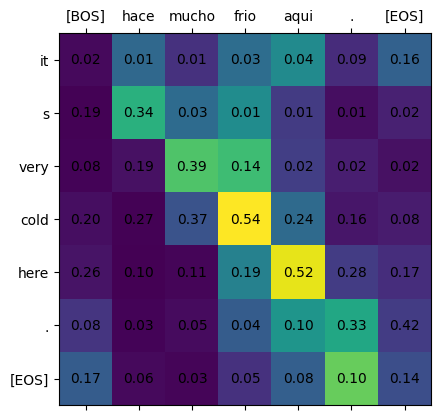

'it s very cold here .'

In [39]:
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
translator(u'hace mucho frio aqui .')

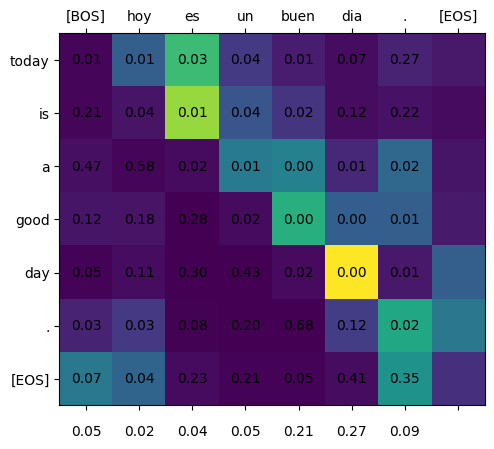

'today is a good day .'

In [40]:
translator(u'Hoy es un buen día.')

In [42]:
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu" ,weights_only=True))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0] #通过tokenizer转换成文字

        return " ".join(trg_sentence[:-1])

from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu_on_test_set(test_data, translator):
    """
    在测试集上计算平均 BLEU 分数。
    :param test_data: 测试集数据，格式为 [(src_sentence, [ref_translation1, ref_translation2, ...]), ...]
    :param translator: 翻译器对象（Translator 类的实例）
    :return: 平均 BLEU 分数
    """
    total_bleu = 0.0
    num_samples = len(test_data)
    i=0
    for src_sentence, ref_translations in test_data:
        # 使用翻译器生成翻译结果
        candidate_translation = translator(src_sentence)

        # 计算 BLEU 分数
        bleu_score = sentence_bleu([ref_translations.split()], candidate_translation.split(),weights=(1, 0, 0, 0))
        total_bleu += bleu_score

        # 打印当前句子的 BLEU 分数（可选）
        # print(f"Source: {src_sentence}")
        # print(f"Reference: {ref_translations}")
        # print(f"Candidate: {candidate_translation}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print("-" * 50)
        # i+=1
        # if i>10:
        #     break
    # 计算平均 BLEU 分数
    avg_bleu = total_bleu / num_samples
    return avg_bleu
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
evaluate_bleu_on_test_set(test_ds, translator)

0.69637614476965